In [1]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import  TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend.frequent_patterns
from mlxtend.frequent_patterns import fpgrowth
from pyfim import pyeclat
import time
from mlxtend.frequent_patterns import fpmax
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

In [66]:
"""loads dataset
Arguments: file_name = file to read
           sep = define how values are separated"""
def load_transactions (file_name, sep=","):
#input: csv file with one transaction per line,
#           where transactions may have a different number of items
#    output: matrix where each row is a vector of items (transaction)
#    author: Sara C. Madeira, Oct 2017  
    lines = open(file_name, 'rt').readlines()
    transactions_matrix = []
    for l in lines:
        l = l.rstrip('\n')
        transaction = l.split(sep)
        transactions_matrix.append(transaction)
    return transactions_matrix

retail=load_transactions("Online_Retail.txt", sep="\t")

len(retail)

24388

As several pairs columns-value are very prevalent we are going to slighlty edit it so that more relevant results are displayed. Accordingly we are going to remove each occurrence of `country:United Kingdom` from the data set. This was done step by step. When removing these prevalent items, after each removed item the number of itemsets and rules becomes lower (or even zero) for any given threshold.

In [67]:
retail_f=[]
filters=frozenset(['country:United Kingdom','DOTCOM POSTAGE', 'POSTAGE'])
for tr in retail:
    ft=[i for i in tr if i not in filters] # and i.find("edu_num=")<0]
    retail_f.append(ft)

retail=retail_f

In [68]:
tr_enc = TransactionEncoder()
trans_array = tr_enc.fit(retail).transform(retail)
binary_database = pd.DataFrame(trans_array, columns=tr_enc.columns_)
binary_database

,"""ACRYLIC HANGING JEWEL,BLUE""","""ACRYLIC HANGING JEWEL,PINK""","""ACRYLIC JEWEL ANGEL,PINK""","""ACRYLIC JEWEL ICICLE, BLUE""","""ACRYLIC JEWEL ICICLE, PINK""","""ACRYLIC JEWEL SNOWFLAKE, PINK""","""ACRYLIC JEWEL SNOWFLAKE,PINK""","""AIRLINE LOUNGE,METAL SIGN""","""ART LIGHTS,FUNK MONKEY""","""ASSORTED FLOWER COLOUR """"LEIS""""""",...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24383,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
24384,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
24385,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
24386,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Objective 1

In [24]:
"""Computes the frequent itemsets
Arguments: binary_dataset = Binary dataset or sparmatrix
           min_supp = Threshold of minimum support to generate itemsets
           max_length = max length of the the frequent itemsets
           algorithm = specify type of algorithm to use (apriori, fpgrowth or eclat)"""
def compute_itemsets(binary_dataset,min_supp,algorithm,max_length=None):
    if algorithm == 'apriori':
        frequent_itemsets = apriori(binary_dataset, min_support=min_supp,use_colnames=True)
    elif algorithm == 'fpgrowth':
        frequent_itemsets = fpgrowth(binary_dataset, min_support=min_supp,use_colnames=True)
    elif algorithm == 'eclat':
        frequent_itemsets = pyeclat(binary_dataset,min_supp)
    
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    if max_length != None:
        frequent_itemsets = frequent_itemsets[(frequent_itemsets['length'] <= max_length)]
    return frequent_itemsets

In [7]:
"""Computes the Kulczynski metric
Arguments: support = support of A and B
           support_A = support of A
           support_B = support of B"""
def kulc_metric(support,support_A,support_B):
        p_a_b = support / support_A
        #print("p_a_b:",p_a_b)
        p_b_a = support / support_B
        return 0.5*(p_a_b+p_b_a)

In [8]:
"""Computes the imbalanced Ratio
Arguments: support = support of A and B
           support_A = support of A
           support_B = support of B"""
def ir_metric(support,support_A,support_B):
    numerator = abs(support_A-support_B)
    denominator = support_A + support_B - support
    return numerator/denominator

In [15]:
"""Adds the kulc and ir metrics to the correspondig rules
Arguments: support = support of A and B
           support_A = support of A
           support_B = support of B"""
def add_kulc_IR(rules):
    #kulc metric = 1/2 (P(A|B)+P(B|A))
    df = rules[['antecedent support','consequent support','support']].values
    for i,line in enumerate(df):
        support = line[2]
        support_A = line[0]
        support_B = line[1]
        rules.loc[i,'kulc_metric'] = kulc_metric(support,support_A,support_B)
        rules.loc[i,"imbalanced_ratio"] = ir_metric(support,support_A,support_B)
    return rules
    

In [10]:
"""Computes associative rules and outputs the top n-th rules based on measure passed
Arguments: itemsets = frequent_itemsets
           threhold = min_threshold for confidence to extract rules
           measure = measure to filter the returned rules
           n = number of rules to be returned"""
def find_rules(itemsets,threshold,measure,n=None,lengths=False):
    rules = association_rules(itemsets,metric=measure,min_threshold=threshold)
    if lengths==True:
        rules['ante_length'] = rules['antecedents'].apply(lambda x: len(x))
        rules['cons_length'] = rules['consequents'].apply(lambda x: len(x))
    if n != None:
        return rules.sort_values(measure, ascending = False).head(n)
    else:
        return rules.sort_values(measure, ascending = False)

The apriori algorithm had very poor performance probably due to the dataset size. So we just used the more performing fpgrowth and eclat. Next we find a reasonable value for min_support that gives an amount of rules that allow us some flexibility to filter and sort to find the most interesting connections. Let's say we want a minimum of 100 rules to extract the 10 most relevant. With min_support of 0.005 we obtain 228 rules. A priori we don't know what is the minimum support we are interested in because the support is dependent on the specificities of the dataset.

In [64]:
run=True
# run=False

while run:

    min_sups=np.array([0.05, 0.02, 0.01, 0.005, 0.002, 0.001])
    algorithm='fpgrowth'

    n_itemsets=[]
    n_rules=[]
    n_iter=0
    nr=0
    while n_iter < len(min_sups)-1 and nr < 1000: # nr < 100
        ms=min_sups[n_iter]
        t0 = time.time()
        FI = compute_itemsets(binary_database,min_supp=ms,algorithm=algorithm)
        Rules = find_rules(FI,0.6,'confidence',lengths=True)
        t1 = time.time()
        print("Elapsed Time: ", t1-t0)
        n=FI.shape[0]
        nr=Rules.shape[0]
        print(ms, "---->", n, "itemsets, ", nr, "rules")
        n_itemsets.append(n)
        n_rules.append(nr)
        n_iter += 1

    break

Elapsed Time:  0.7669780254364014
0.05 ----> 13 itemsets,  0 rules
Elapsed Time:  4.254595518112183
0.02 ----> 272 itemsets,  22 rules
Elapsed Time:  13.558898210525513
0.01 ----> 1214 itemsets,  228 rules
Elapsed Time:  26.73112416267395
0.005 ----> 8749 itemsets,  6598 rules


In [ ]:
while run:

    #simple direct plot
    plt.plot(np.log(min_sups), np.log(n_itemsets), '--bo')
    plt.grid()
    plt.show()

    break

Below we compute the itemsets and the extract the rules according to a metric of interest, in thise case "confidence" above a threshold of 60%, which is a common value in these types of analysis, although it is also dependent on the dataset. Other rules could have been used.

In [69]:
t0 = time.time()
#Get freq_itemsets Fp-Growth
freq_itemsets_fpg = compute_itemsets(binary_database,0.005,'fpgrowth') # without max_length
#Get Rules
rules_fpg = find_rules(freq_itemsets_fpg,0.6,'confidence',lengths=True)
#Add Kulc and IR metrics
rules_fpg = add_kulc_IR(rules_fpg)
t1 = time.time()
print("Elapsed Time: ", t1-t0)

Elapsed Time:  17.64932680130005


In [70]:
rules_fpg['ante_length'].value_counts()

2    2414
3    2016
4     427
1     393
5      30
Name: ante_length, dtype: int64

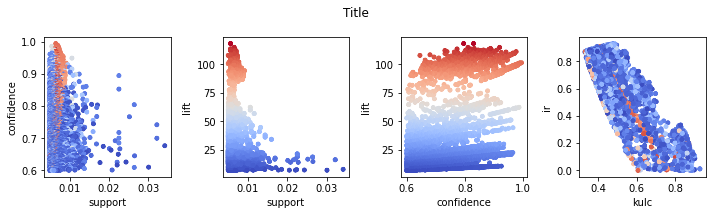

In [71]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))
fig.suptitle('Title')

support = rules_fpg['support'].values
confidence = rules_fpg['confidence'].values
lift = rules_fpg['lift'].values

x = support
y = confidence
z = lift

k = rules_fpg['kulc_metric'].values
r = rules_fpg['imbalanced_ratio'].values

scaled_z = (z - z.min()) / z.ptp()
colors = plt.cm.coolwarm(scaled_z)

ax1.scatter(x, y, marker='*', edgecolors=colors, s=1, linewidths=4)
ax1.set_xlabel('support')
ax1.set_ylabel('confidence')

ax2.scatter(x, z, marker='*', edgecolors=colors, s=1, linewidths=4)
ax2.set_xlabel('support')
ax2.set_ylabel('lift')

ax3.scatter(y, z, marker='*', edgecolors=colors, s=1, linewidths=4)
ax3.set_xlabel('confidence')
ax3.set_ylabel('lift')

ax4.scatter(k, r, marker='*', edgecolors=colors, s=1, linewidths=4)
ax4.set_xlabel('kulc')
ax4.set_ylabel('ir')

fig.tight_layout()
plt.show()


Filter considering the extended dataframe with column length.

In [ ]:
freq_itemsets_fpg.sort_values(['support'],ascending=False).groupby('length').head(2)

In general it is understood that rules with a greater number of items, wether in the antecedent or the consequent, are more interesting that rules with fewer items. So we group by the antecedent length of our extended dataframe. We also order based on interesting metrics like the support and lift knowing that previously we already filtered by rules with "confidence" above 60%.

In [ ]:
rules_fpg.sort_values(['support','lift'],ascending=False).groupby('ante_length').head(2)

In [ ]:
rules_fpg.sort_values(['kulc_metric'],ascending=False).groupby('ante_length').head(2)

In [ ]:
rules_fpg.sort_values(['support','kulc_metric'],ascending=False).groupby('ante_length').head(2)

#### Selected Rules

In [94]:
#Selected Rules
index = [89,2354,354,2289,763,413,1665,1173,450,559]
rules_fpg.loc[index]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante_length,cons_length,kulc_metric,imbalanced_ratio
89,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.050476,0.087543,0.034156,0.676686,7.729747,0.029737,2.822197,1,1,0.535026,0.865658
2354,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.045924,0.043341,0.032147,0.700000,16.150993,0.030157,3.188863,1,1,0.421102,0.850909
354,"(PACK OF 72 RETROSPOT CAKE CASES, WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE BAG)","(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SUKI DESIGN)",0.007709,0.020912,0.005823,0.755319,36.119065,0.005661,4.001490,3,2,0.900016,0.007576
2289,"(HERB MARKER THYME, HERB MARKER CHIVES, HERB MARKER PARSLEY, HERB MARKER BASIL, HERB MARKER ROSEMARY)",(HERB MARKER MINT),0.006807,0.009882,0.006479,0.951807,96.318152,0.006411,20.544950,5,1,0.492279,0.643082
763,"(RED RETROSPOT CHARLOTTE BAG, STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI DESIGN)",(WOODLAND CHARLOTTE BAG),0.013777,0.034566,0.010702,0.776786,22.472420,0.010226,4.325144,3,1,0.900794,0.088000
413,"(CHARLOTTE BAG PINK POLKADOT, WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI DESIGN)",(RED RETROSPOT CHARLOTTE BAG),0.009144,0.043054,0.008406,0.919283,21.351868,0.008012,11.855498,4,1,0.897279,0.003802
1665,(HEART WOODEN CHRISTMAS DECORATION),(STAR WOODEN CHRISTMAS DECORATION),0.009144,0.009062,0.006315,0.690583,76.207861,0.006232,3.202597,1,1,0.873745,0.174888
1173,(SET/6 RED SPOTTY PAPER CUPS),(SET/20 RED RETROSPOT PAPER NAPKINS),0.017550,0.040512,0.012137,0.691589,17.071323,0.011426,3.111068,1,1,0.871324,0.100877
450,"(RED RETROSPOT CHARLOTTE BAG, LUNCH BAG BLACK SKULL., STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI DESIGN)",(LUNCH BAG RED RETROSPOT),0.007176,0.065893,0.005084,0.708571,10.753354,0.004612,3.205269,4,1,0.887515,0.007491
559,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SUKI DESIGN, CHARLOTTE BAG PINK POLKADOT, WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE BAG)",(LUNCH BAG CARS BLUE),0.008406,0.048097,0.005043,0.600000,12.474680,0.004639,2.379756,5,1,0.864916,0.025532


### Objective 2

In [77]:
"""Computes the maximal itemsets
Arguments: binary_dataset = Binary dataset or sparmatrix
           min_supp = Threshold of minimum support to generate itemsets
           max_length = max length of the the frequent itemsets"""
def compute_max_itemsets(binary_dataset,min_supp,max_length=None):
    max_itemsets = fpmax(binary_dataset, min_support=min_supp,use_colnames=True)
    max_itemsets['length'] = max_itemsets['itemsets'].apply(lambda x: len(x))
    if max_length != None:
        max_itemsets = max_itemsets[(max_itemsets['length'] <= max_length)]
    return max_itemsets

In [78]:

FMI = compute_max_itemsets(binary_database,min_supp=0.005)
FMI

,support,itemsets,length
0,0.005002,(RED 3 PIECE RETROSPOT CUTLERY SET),1
1,0.005002,(PING MICROWAVE APRON),1
2,0.005002,(STAR T-LIGHT HOLDER WILLIE WINKIE),1
3,0.005002,(DOORMAT WELCOME SUNRISE),1
4,0.005002,(TABLECLOTH RED APPLES DESIGN),1
...,...,...,...
5325,0.013244,"(ASSORTED COLOUR BIRD ORNAMENT, WHITE HANGING HEART T-LIGHT HOLDER)",2
5326,0.005454,"(REGENCY CAKESTAND 3 TIER, LUNCH BAG RED RETROSPOT, PARTY BUNTING)",3
5327,0.005248,"(JUMBO BAG RED RETROSPOT, LUNCH BAG RED RETROSPOT, PARTY BUNTING)",3
5328,0.006233,"(JUMBO BAG RED RETROSPOT, WHITE HANGING HEART T-LIGHT HOLDER, LUNCH BAG RED RETROSPOT)",3


In [ ]:
itemsets_max = set()
for i, val in enumerate(FMI['itemsets'].values):
    for el in val:
        if el not in itemsets_max:
            itemsets_max.add(el)
            
#itemsets_max

In [90]:
t0 = time.time()
freq_max_itemsets = compute_itemsets(binary_database[list(itemsets_max)],min_supp=0.01,algorithm='fpgrowth')
rules_max = find_rules(freq_max_itemsets,0.6,'confidence',lengths=True)
rules_max = add_kulc_IR(rules_max)
t1 = time.time()
print("Elapsed Time: ", t1-t0)

Elapsed Time:  10.03815221786499


In [ ]:
rules_max.sort_values(['support','lift'],ascending=False).groupby('ante_length').head(3)

In [ ]:
rules_max.sort_values(['confidence','kulc_metric'],ascending=False).groupby('ante_length').head(3)

In [ ]:
rules_max.sort_values(['kulc_metric','imbalanced_ratio'],ascending=False).groupby('ante_length').head(3)

In [ ]:
rules_max.sort_values(['confidence','kulc_metric'],ascending=False).groupby('ante_length').head(3)

#### Selected Rules

In [95]:
index = [4,0,77,167,204]
rules_max.loc[index]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante_length,cons_length,kulc_metric,imbalanced_ratio
4,"(ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELIKE GREEN)",(ALARM CLOCK BAKELIKE RED),0.017181,0.044325,0.012875,0.749403,16.906983,0.012114,3.813598,2,1,0.814330,0.172249
0,(POPPY'S PLAYHOUSE BEDROOM),(POPPY'S PLAYHOUSE KITCHEN),0.017468,0.018042,0.012875,0.737089,40.854844,0.012560,3.734949,1,1,0.808462,0.285000
77,"(LUNCH BAG CARS BLUE, LUNCH BAG PINK POLKADOT)",(LUNCH BAG BLACK SKULL.),0.020789,0.053100,0.012752,0.613412,11.552044,0.011648,2.449379,2,1,0.814330,0.172249
167,"(PINK REGENCY TEACUP AND SAUCER, REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACUP AND SAUCER)",(ROSES REGENCY TEACUP AND SAUCER),0.014187,0.045924,0.012424,0.875723,19.068858,0.011773,7.676982,3,1,0.431483,0.559633
204,"(REGENCY TEA PLATE PINK, REGENCY TEA PLATE ROSES)",(REGENCY TEA PLATE GREEN),0.011153,0.015827,0.010579,0.948529,59.929366,0.010402,19.121067,2,1,0.441386,0.469880
